In [1]:
import gym

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from VPG import VanillaPolicyGradient
from DQN import DeepQNetwork
from mountain_car_wrappers import RewardEnergy

## Vanilla Policy Gradient does not work as well

In [2]:
with gym.make('MountainCar-v0') as env:
    env = RewardEnergy(env)
    model = VanillaPolicyGradient(state_space_dims=2,
                                    action_space_dims=3,
                                    actor_shape=32,
                                    critic_shape=32,
                                    lr=1e-3)
    
    model.train(env, epochs=1000, gamma=0.99, render=False)

2022-07-06 14:57:24.383903: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 195
Trainable params: 195
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________
Epoch: 0
Iters: 200, Rewards: -7.373, 

# Deep Q Network (DQN)

## Future Reward

The optimum strategy maximizes the sum of future reward:
$$\pi^*(s_t) = \argmax_{a\in A(t)} \sum_{i=t}^\infty r_i$$
where $\pi^*$ is the optimal strategy and $A$ is all possible actions at time $t$, $r_i$ is the reward at time $i$

However, we usually only have finite time steps, so we use a discount factor $\gamma$ 
$$\pi^*(s_t) = \argmax_{a\in A(t)} \sum_{i=t}^T \gamma^{i-t} r_i$$

We use a function $Q$ to predict the discounted reward at for each state and action:
$$Q^*(s_t, a_t) = r_t + \gamma \max_{a_{t+1}\in A(t+1)}Q^*(s_{t+1}, a_{t+1})$$
and the optimum policy will be
$$\pi^*(s_t) = \argmax_{a\in A(t)}Q^*(s_t, a)$$

## Experiences



In [5]:
with gym.make('MountainCar-v0') as env:
    env = RewardEnergy(env)
    model = DeepQNetwork(dims=[2, 32, 32, 3],
                         epsilon=1.0, epsilon_decay=.01, gamma=.95,
                         memory=100000, start_updating=2000,
                         batch_size=256, learning_rate=1e-3)
    # model.load('./dqn_self/')
    model.train(env, episodes=500)
    model.save('./dqn_reward_e/')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________
Episode: 0
iters: 200, tot_rwd: -7.23
Episode: 1
iters: 200, tot_rwd: -0.17
Episode: 2
iters: 200, tot_rwd: -0.77
Episode: 3
iters: 200, tot_rwd: 0.10
Episode: 4
iters: 200, tot_rwd: 0.83
Episode: 5
iters: 200, tot_rwd: -0.51
Episode: 6
iters: 200, tot_rwd: 0.01
Episode: 7
iters: 200, tot_rwd: -0.36
Episode: 8
iters: 200, tot_rwd: 2.72
Episode: 9
iters: 200, tot_rwd: -2.23, lss: 

In [6]:
with gym.make('MountainCar-v0') as env:
    iters, total_rwd = model.simulate(env, render=True, evaluation=True)
print(f'Iterations: {iters}, Total Reward: {total_rwd}')

2022-07-06 14:55:32.047 python[84421:529419] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f79b67eaac0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-07-06 14:55:32.048 python[84421:529419] Warning: Expected min height of view: (<NSButton: 0x7f79b53a67a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-07-06 14:55:32.052 python[84421:529419] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f79b7130010>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-07-06 14:55:32.056 python[84421:529419] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f79b7131100>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Iterations: 99, Total Reward: -99.0


/var/folders/wz/gr0d0g59325_bxkgsxrg4sxw0000gn/T/ipykernel_84421/412379532.py:8: UserWarning: The following kwargs were not used by contour: 'label'
  cs = plt.contourf(xm, vm, controls, label='control choice')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


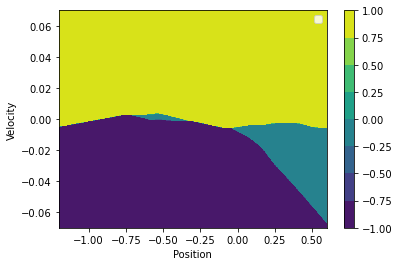

In [8]:
x = np.linspace(-1.2, 0.6, 500)
v = np.linspace(-0.07, 0.07, 500)
xm, vm = np.meshgrid(x, v)
inputs = np.vstack((xm.flatten(), vm.flatten())).T
model.q_net.compile(optimizer='adam', loss='mse')
controls = tf.argmax(model.q_net.predict(inputs), axis=-1)
controls = tf.reshape(controls - 1, [500, 500])
cs = plt.contourf(xm, vm, controls, label='control choice')
plt.colorbar(cs)
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.legend()